## Graph DB 연결하기

In [ ]:
from neo4j import GraphDatabase

URI = "neo4j+s://your-database-uri"
AUTH = ("your-username", "your-password")

with GraphDatabase.driver(URI, auth=AUTH) as driver:
    driver.verify_connectivity()

## 텍스트에서 Node, Relationships 추출하기

In [ ]:
import getpass
import os

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

## Text Split 하기

https://neo4j.com/docs/neo4j-graphrag-python/current/api.html#textsplitter

In [ ]:
from neo4j_graphrag.experimental.components.types import TextChunks, TextChunk

text = """
Marie Curie, 7 November 1867 – 4 July 1934, was a Polish and naturalized-French physicist and chemist who conducted pioneering research on radioactivity. 
She was the first woman to win a Nobel Prize, and she remains the only person to win Nobel Prizes in two different scientific fields: Physics and Chemistry.
Her husband, Pierre Curie, was a co-winner of her first Nobel Prize, making them the first-ever married couple to win the Nobel Prize.
She was, in 1906, the first woman to become a professor at the University of Paris.
Also, Robin Williams.
"""


In [ ]:
from langchain_text_splitters import CharacterTextSplitter
from neo4j_graphrag.experimental.components.text_splitters.langchain import LangChainTextSplitterAdapter

splitter = LangChainTextSplitterAdapter(
    langchain_text_splitter=CharacterTextSplitter(
        separator=".",
        chunk_size=4000,
        chunk_overlap=200
    )
)

In [ ]:
chunks = await splitter.run(text=text)

In [ ]:
chunks

## 2. Text Chunk 임베딩 추가하기
OpenAIEmbeddings(): Defaults to "text-embedding-ada-002"

In [ ]:
from neo4j_graphrag.experimental.components.embedder import TextChunkEmbedder
from neo4j_graphrag.embeddings.openai import OpenAIEmbeddings

embedder = OpenAIEmbeddings()
chunk_embedder = TextChunkEmbedder(embedder=embedder)

In [ ]:
chunks_with_embeddings = await chunk_embedder.run(text_chunks=chunks)
chunks_with_embeddings

## 3. LLM으로 Node, Relationsips 추출하기

In [ ]:
from neo4j_graphrag.experimental.components.entity_relation_extractor import (
    LLMEntityRelationshipExtractor
)
from neo4j_graphrag.llm import OpenAILLM

extractor = LLMEntityRelationshipExtractor(
    llm=OpenAILLM(
        model_name="gpt-40",
        model_params={
            "max_tokens": 1000,
            "response_format": {"type": "json_object"}
        }
    )
)
extract_results = await extractor.run(text_chunks=chunks_with_embeddings)

In [ ]:
extract_results

In [ ]:
# nodes
extract_results.nodes

In [ ]:
# relationships
extract_results.relationships

## GraphDB 적재하기

In [ ]:
from neo4j_graphrag.experimental.components.kg_writer import Neo4jWriter
from neo4j_graphrag.experimental.components.types import Noe4jGraph

driver = GraphDatabase.driver(URI, auth=AUTH)

writer = Neo4jWriter(neo4j_driver=driver)
graph = Noe4jGraph(
    nodes=extract_results.nodes,
    relationships=extract_results.relationships
)  
await writer.run(graph=graph)

# Vector 기반 Graph DB 구축하기

## 1. Vector INDEX 추가하기
- Vector index를 추가한다는 것은 위의 vector embedding을 가지는 노드에 검색이 빠르도록 index를 추가하는 것

neo4j graph db 쿼리

```
CREATE VECTOR INDEX vectorchunk IF NOt EXISTS
FOR (c:Chunk)
ON c.embedding
OPTIONS { indexConfig: {
    `vector.dimensions` : 1536,
    `vector.similarity_function`: 'cosine'}
}
```

In [ ]:
from neo4j import GraphDatabase
from neo4j_graphrag.indexes import create_vector_index

INDEX_NAME = "vectorchunk"
DIMENSION = 1536  # OpenAI Embeddings dimension

create_vector_index(
    driver,
    INDEX_NAME,
    label="Chunk",
    embedding_property="embedding",
    dimension=DIMENSION,
    similarity_fn="cosine"
)

## Vector Retriever 사용하기

In [ ]:
import neo4j
from neo4j_graphrag.retrievers import VectorRetriever
from neo4j_graphrag.embeddings.openai import OpenAIEmbeddings

retriever = VectorRetriever(
    driver,
    "vectorchunk",
    embedder=OpenAIEmbeddings()
)

retriever.search(query_text="Who is Marie Curie?", top_k=1)


## GraphRAG 파이프라인 모듈 사용하기

In [ ]:
from neo4j_graphrag.retrievers import VectorRetriever
from neo4j_graphrag.llm.openai_llm import OpenAILLM
from neo4j_graphrag.generation import GraphRAG

retriever = VectorRetriever(driver, "vectorchunk", embedder=OpenAIEmbeddings())
llm = OpenAILLM(model_name="gpt-4o")
graph_rag = GraphRAG(retriever=retriever, llm=llm)
response = graph_rag.search(query="Who is Marie Curie?", retriever_config={"top_k": 3}, return_context=True)

In [ ]:
print(response.answer)

In [ ]:
print(response.retriever_result)

# 사전구축 파이프라인 : SimpleKGPipeline

: 논문 PDF에서 그래프 추출하고 GraphRAG 구현하기
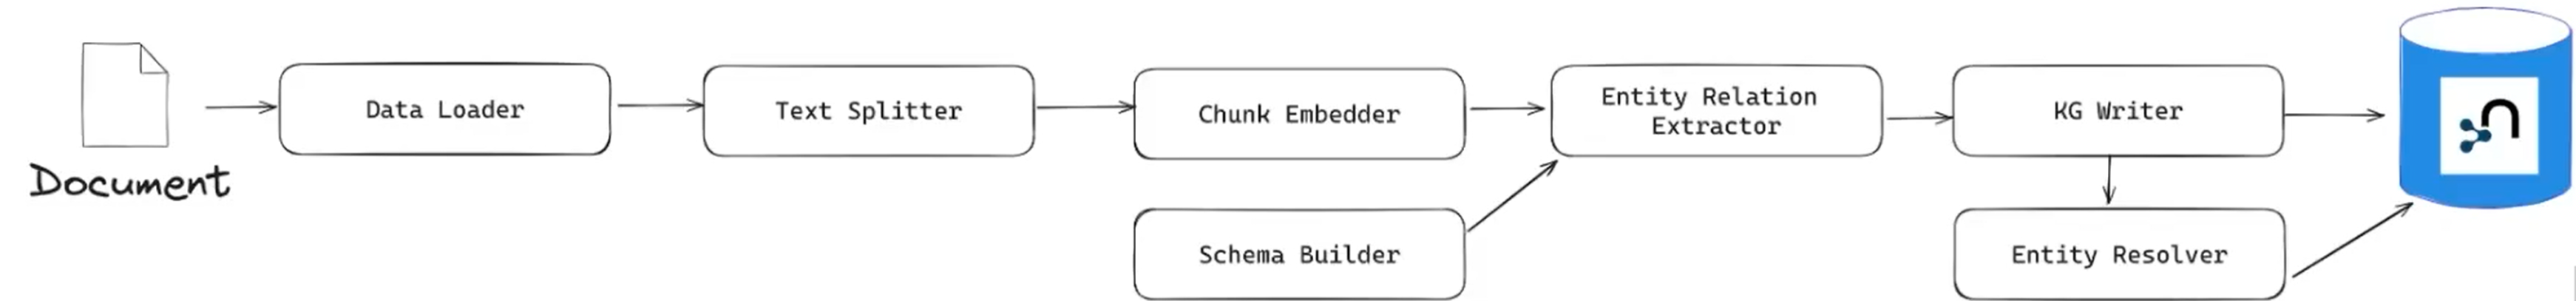


pip install rapidfuzz spacy

In [ ]:
import neo4j
from neo4j_graphrag.embeddings.openai import OpenAIEmbeddings

neo4j_driver = neo4j.GraphDatabase.driver(URI, auth=AUTH)

In [ ]:
from neo4j_graphrag.llm.openai_llm import OpenAILLM

llm = OpenAILLM(model_name="gpt-4o")

In [ ]:
from neo4j_graphrag.experimental.pipeline.kg_builder import SimpleKGPipeline

kg_builder = SimpleKGPipeline(
    llm=llm,    # an LLMInterface for Entity and Relation Extraction
    driver=neo4j_driver,   # Neo4j Driver to write result to graph
    embedder=OpenAIEmbeddings(),    # an Embedder for chunks
    from_pdf=True    # set to False if parsing an already extracted text
)
await kg_builder.run_async(pdf_path="GraphRAG.pdf")

In [ ]:
# 벡터 인덱스 추가

from neo4j import GraphDatabase
from neo4j_graphrag.indexes import create_vector_index

INDEX_NAME = "graphragchunk"
DIMENSION = 1536  # OpenAI Embeddings dimension

# Creating the index
with GraphDatabase.driver(URI, auth=AUTH) as driver:
    create_vector_index(
        driver,
        INDEX_NAME,
        label="Chunk",
        embedding_property="embedding",
        dimension=DIMENSION,
        similarity_fn="cosine"
    )

In [ ]:
import neo4j
from neo4j_graphrag.retrievers import Neo4jVectorRetriever
from neo4j_graphrag.embeddings.openai import OpenAIEmbeddings

retriever = VectorRetriever(driver, "graphragchunk", embedder=OpenAIEmbeddings())
retriever.search(query_text="What is GraphRAG?", top_k=3)

In [ ]:
from neo4j_graphrag.llm.openai_llm import OpenAILLM
from neo4j_graphrag.generation import GraphRAG

llm = OpenAILLM(model_name="gpt-4o")
graph_rag = GraphRAG(retriever=retriever, llm=llm)

query_text = "What is GraphRAG?"
response = graph_rag.search(
    query=query_text,
    retriever_config={"top_k": 3},
    return_context=True
)
print(response.answer)

In [ ]:
print(response.retriever_result)

In [ ]:
print(response.retriever_result.items[0].content[100:])

## 임베딩 직접 추가하기

도메인 property와 같은 경우 embedding이 되어있지 않을 수 있으니
해당 도메인 property에 embedding property만 추가하여 vector retrieve를 하는 경우

https://sandbox.neo4j.com/?usecase=stackoverflow

In [ ]:
from neo4j import GraphDatabase

URI = "neo4j+s://your-database-uri"
AUTH = ("your-username", "your-password")

with GraphDatabase.driver(URI, auth=AUTH) as driver:
    driver.verify_connectivity()

In [ ]:
from neo4j_graphrag.embeddings.sentence_transformers import SentenceTransformersEmbeddings

# 비용 안들이고 임베딩 할 때
embedder = SentenceTransformersEmbeddings(model_name="all-MiniLM-L6-v2")

In [ ]:
driver = GraphDatabase.driver(URI, auth=AUTH)

with driver.session() as session:
    # stackoverflow Question 노드들 중 embedding이 없는 것들을 찾아서 본문 내용 임베딩 추가
    result = session.run("MATCH (q:Question) WHERE q.embedding IS NOT NULL RETURN elementId(q) AS id, q.body_markdown AS text")
    records = result.data()

    for record in records:
        node_id = record["id"]
        text = record["text"]
        vector = embedder.embed_query(text)
        
        session.run("""
            MATCH (q) WHERE elementId(q) = $id
            SET q.embedding = $embedding
            """,
            {
                "id": node_id,
                "embedding": vector
            }
        )


In [ ]:
from neo4j import GraphDatabase
from neo4j_graphrag.indexes import create_vector_index

INDEX_NAME = "qeustionindex"
DIMENSION = 384  # SentenceTransformers 'all-MiniLM-L6-v2' dimension

# Creating the index
with GraphDatabase.driver(URI, auth=AUTH) as driver:
    create_vector_index(
        driver,
        INDEX_NAME,
        label="Question",
        embedding_property="embedding",
        dimension=DIMENSION,
        similarity_fn="cosine"
    )

In [ ]:
from neo4j_graphrag.retrievers import VectorRetriever
from neo4j_graphrag.llm.openai_llm import OpenAILLM
from neo4j_graphrag.generation import GraphRAG

retriever = VectorRetriever(driver, "qeustionindex", embedder=embedder)
llm = OpenAILLM(model_name="gpt-4o")
graph_rag = GraphRAG(retriever=retriever, llm=llm)
response = graph_rag.search(query="What are some possible questions that could arise under the topic 'Cypher - get all associated relationships for a node'?", return_context=True)

In [ ]:
print(response.answer)

In [ ]:
print(response.retriever_result)